# Project Description

Dataset Link: https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset/data 

# Get The Data

In [78]:
import os
import zipfile

SAMPLE_SIZE_PER_CLASS = 20
IMAGE_DIMENSION = (128, 128)
IMAGE_DISPLAY_COUNT = 5
NUM_LABELS = 5

dataset_file = "Grapevine_Leaves_Image_Dataset.zip"
data_top_folder = "Data"
dataset_folder = "Data/Grapevine_Leaves_Image_Dataset"

with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
    zip_ref.extractall(data_top_folder)

# Checking the contents of the extracted dataset folder

extracted_files = os.listdir(dataset_folder)
extracted_files


['Ak',
 'Ala_Idris',
 'Buzgulu',
 'Dimnit',
 'Grapevine_Leaves_Image_Dataset_Citation_Request.txt',
 'Nazli']

# Visualize the Dataset

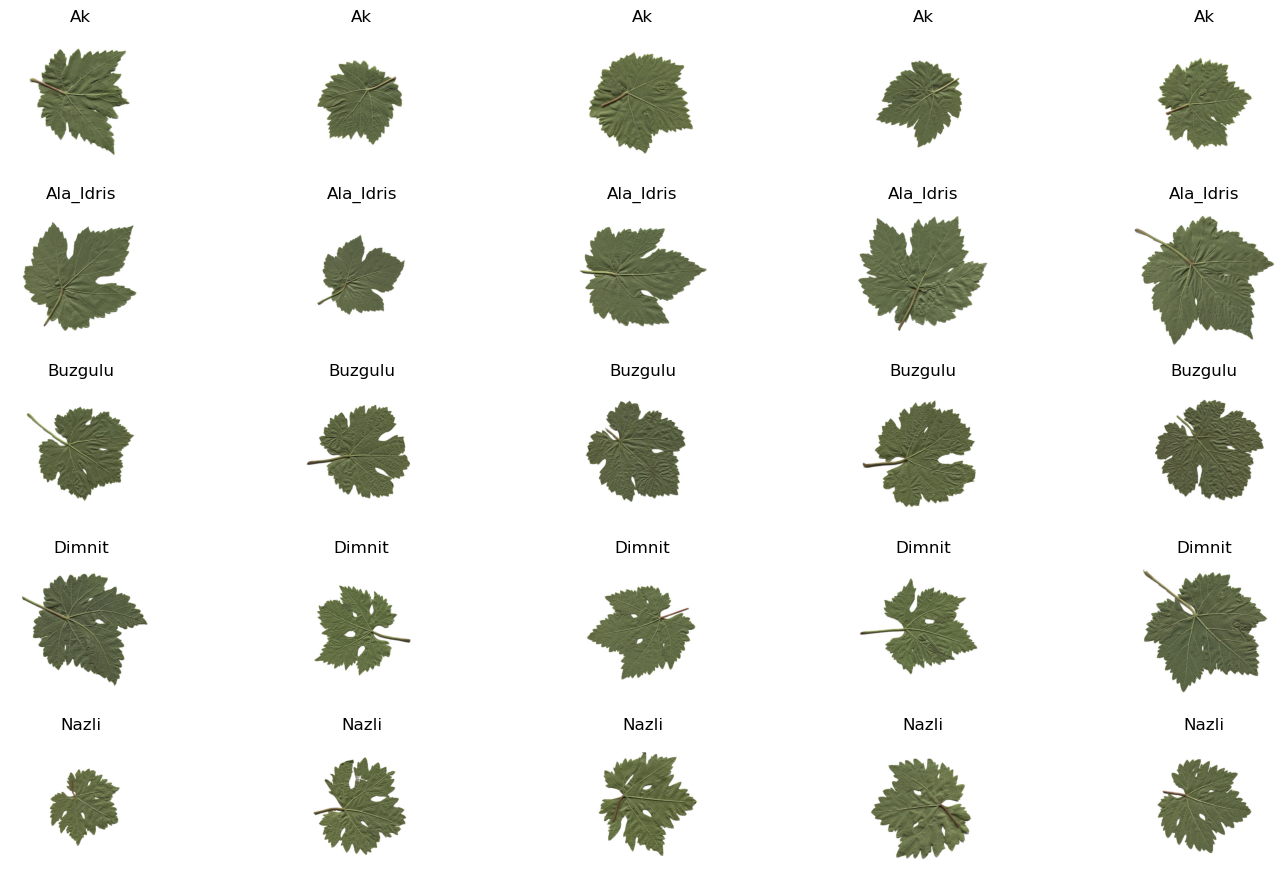

In [79]:
from pathlib import Path
import random
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2


fig, axs = plt.subplots(5, IMAGE_DISPLAY_COUNT, figsize=(15, 9)) # 5 rows, x columns. rows are classes

# Counter for subplot position
subplot_counter = 0

for label_folder in os.listdir(dataset_folder):
    folder_path = Path(dataset_folder) / label_folder
    if folder_path.is_dir():
        image_files = [image_file for image_file in folder_path.iterdir() if image_file.is_file() and image_file.suffix == '.png']
        
        # Randomly select k files from the list
        selected_files = random.sample(image_files, k=IMAGE_DISPLAY_COUNT)
        
        for image_file in selected_files:
            if subplot_counter < IMAGE_DISPLAY_COUNT*5:  # To make sure we don't exceed 15 images
                # Read the image
                img = cv2.imread(str(image_file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Determine subplot position
                ax = axs[subplot_counter // IMAGE_DISPLAY_COUNT, subplot_counter % IMAGE_DISPLAY_COUNT]
                ax.imshow(img)
                ax.axis('off')  # Turn off axis
                ax.set_title(label_folder)
                subplot_counter += 1

# Adjust layout
plt.tight_layout()
plt.show()

# Preprocessing

In [80]:
import pandas as pd
import numpy as np
from skimage.feature import corner_harris, corner_peaks
from sklearn.preprocessing import StandardScaler

def extract_features(image_path, resize_dim=IMAGE_DIMENSION):
    """
    Extract color histograms, edges, and corners from the image.
    - Color histograms for color features
    - Canny edge detection for edge features
    - Harris corner detection for corner features
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, resize_dim)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Color histogram features (using the grayscale image)
    color_hist = cv2.calcHist([image_gray], [0], None, [256], [0, 256]).flatten()

    # Edge detection features
    edges = cv2.Canny(image_gray, 100, 200).flatten()
    edge_hist = np.histogram(edges, bins=[0, 128, 256])[0]

    # Corner detection features
    corners = corner_harris(image_gray)
    corner_count = len(corner_peaks(corners, min_distance=5))

    print(f"Image path: {image_path}")
    print(f"Color hist shape: {color_hist.shape}")
    print(f"Edges shape: {edges.shape}")
    print(f"Corners shape: {corner_count}")
    print("===========================================")

    return np.concatenate([color_hist, edge_hist, [corner_count]])

# Creating a dataframe to store features and labels
data = []
labels = []
image_paths = []

# Process each folder (label) in the dataset
for label_folder in os.listdir(dataset_folder):
    folder_path = Path(dataset_folder) / label_folder
    if folder_path.is_dir():
        # Get a list of all image files in the folder
        image_files = [image_file for image_file in folder_path.iterdir() if image_file.is_file() and image_file.suffix == '.png']
        
        # Randomly select k files from the list
        selected_files = random.sample(image_files, k=SAMPLE_SIZE_PER_CLASS)
        
        # Process each selected image file
        for image_file in selected_files:
            features = extract_features(str(image_file))
            data.append(features)
            labels.append(label_folder)
            image_paths.append(str(image_file))

# Convert to a DataFrame
features_df = pd.DataFrame(data)
features_df['image_path'] = image_paths
features_df['label'] = labels

# Separate the features from the image paths
numeric_features = features_df.drop([ 'image_path', 'label'], axis=1)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Re-creating the dataframe with scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)
scaled_features_df['image_path'] = features_df['image_path']
scaled_features_df['label'] = features_df['label']


scaled_features_df.head()

Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (32).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 105
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (22).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 104
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (74).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 104
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (11).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 91
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (5).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 90
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (63).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 99
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (36).png
Color hist shape: (256,)
Edges shape: (16384,)
Corners shape: 93
Image path: Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (43).png
Color hist shape: (256,)
Edges shape: (

,0,1,2,3,4,5,6,7,8,9,...,251,252,253,254,255,256,257,258,image_path,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.455411,-1.135472,-0.259206,0.016604,-0.222419,0.286728,-0.286728,-0.247238,Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (32)...,Ak
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.914366,-0.821517,-0.151203,-0.104886,-0.245463,0.416716,-0.416716,-0.320602,Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (22)...,Ak
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.069465,0.015698,-0.691216,0.016604,-0.152163,0.117442,-0.117442,-0.320602,Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (74)...,Ak
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.553669,-0.402909,-1.015223,0.887276,-1.272324,-1.681222,1.681222,-1.274339,Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (11)...,Ak
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.167724,-0.716865,0.118803,-0.125134,-0.918796,-0.490174,0.490174,-1.347704,Data\Grapevine_Leaves_Image_Dataset\Ak\Ak (5).png,Ak


### Visualize Extracted Features

7852
8113
6656
7366
8417


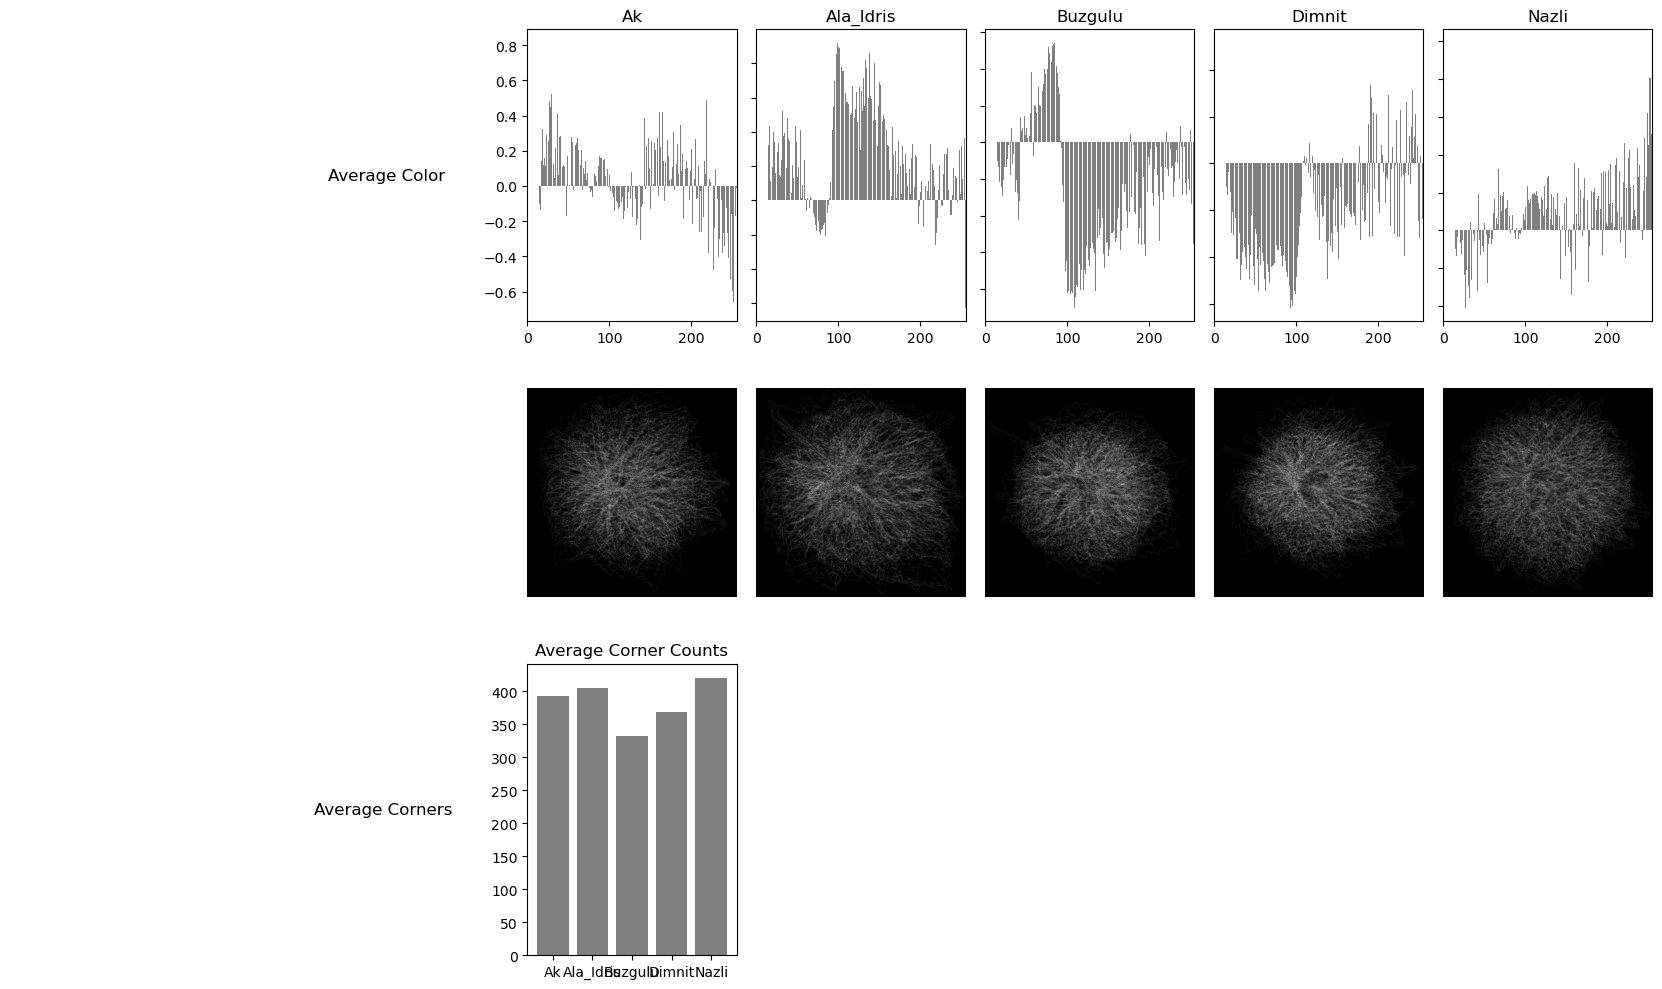

In [81]:
N = 256  # Adjust this based on how many color histogram features you have

# Extract color features and labels
color_features = scaled_features_df.iloc[:, :N]
labels = scaled_features_df['label']

# Group by label and calculate the mean
average_colors = color_features.groupby(labels).mean()

def compute_average_edge_image(image_paths):
    # Initialize an array to accumulate edge images
    sum_edges = None
    count = 0

    for image_path in image_paths:
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(image, 100, 200)

        if sum_edges is None:
            sum_edges = np.zeros_like(edges, dtype=np.float32)
        
        sum_edges += edges
        count += 1

    # Compute the average
    avg_edges = sum_edges / count
    return avg_edges


def compute_average_corner_count(image_paths):
    total_corners = 0
    quality_level = 0.01  # Adjust this threshold as needed
    for image_path in image_paths:
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        corners = cv2.goodFeaturesToTrack(image, 0, quality_level, 10)
        total_corners += len(corners) if corners is not None else 0
    print(total_corners)
    return total_corners / len(image_paths)

average_edge_images = {}
average_corner_counts = {}

for label in average_colors.index:
    image_files = scaled_features_df[scaled_features_df['label'] == label]['image_path']
    average_edge_images[label] = compute_average_edge_image(image_files)
    average_corner_counts[label] = compute_average_corner_count(image_files)


bins = 256

num_labels = average_colors.shape[0]
fig, axs = plt.subplots(3, num_labels, figsize=(15, 10))  # Adjust the size as needed

for i, label in enumerate(average_colors.index):
    axs[0, i].bar(range(bins), average_colors.loc[label], color='gray')
    axs[0, i].set_title(label)
    axs[0, i].set_xlim([0, bins - 1])
    if i > 0:
        axs[0, i].set_yticklabels([])  # Hide the y-axis labels for all but the first subplot

for i, label in enumerate(average_edge_images):
    axs[1, i].imshow(average_edge_images[label], cmap='gray')
    axs[1, i].axis('off')  # Turn off axis

# Plotting Average Corner Counts on single bar plot in row 3
axs[2, 0].bar(average_corner_counts.keys(), average_corner_counts.values(), color='gray')
axs[2, 0].set_title('Average Corner Counts')
for j in range(1, num_labels):
    axs[2, j].axis('off')
    
row_labels = ['Average Color', 'Average Edges', 'Average Corners']
for i, label in enumerate(row_labels):
    axs[i, 0].annotate(label, xy=(0, 0.5), xytext=(-axs[i, 0].yaxis.labelpad - 20, 0),
                      xycoords=axs[i, 0].yaxis.label, textcoords='offset points',
                      size='large', ha='right', va='center')
    
plt.tight_layout()
plt.show()